In [11]:
from torchvision.models import resnet152
from inclearn.lib import data
import torch
import pickle
from urllib.request import urlopen
from torchvision import transforms
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]

In [2]:
model = resnet152(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [3]:
imagenet_class_map = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

In [4]:
BATCH_SIZE = 16

In [5]:
class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

dataset_args = {
            "resize_res": 224,
            "use_cache": False
        }
inc_dataset = data.IncrementalDataset(
        dataset_name="cityscapes",
        root="/media/romilb/NEW VOLUME/cityscapes/dataset",
        sample_list_name="pedvehicle",
        random_order=False,
        shuffle=False,
        batch_size=BATCH_SIZE,
        workers=10,
        increment=10,
        validation_split=0,
        is_sampleincremental=True,
        task_data_distribution="uniform_class",
        use_train_for_test=True,
        dataset_args=dataset_args
    )

Using data cache: False
Using data cache: False
Using data cache: False


In [6]:
for taskid in range(inc_dataset.n_tasks):
    print("Task id: {}".format(taskid))
    print("Using sample incremental protocol")
    task_info, train_loader, val_loader, test_loader = inc_dataset.new_task_incr()
    for i_batch, sample_batched in enumerate(test_loader):
        iputs, targets = sample_batched
        #print(iputs)
        result=model(iputs)
        values, indices = result.topk(5)
        for row in indices:
            for i in row:
                val = i.item()
#                 print(val)
#                 print(imagenet_class_map[val])
        break
    break

Task id: 0
Using sample incremental protocol
Initializing indexes for sample incremental using uniform_class task data distribution
Using data cache: False
Using data cache: False
Using data cache: False


In [7]:
imagenet_class_map

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [8]:
reverse_trsf =transforms.Compose([
    NormalizeInverse(
                             mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]
                         ),
          transforms.ToPILImage()])

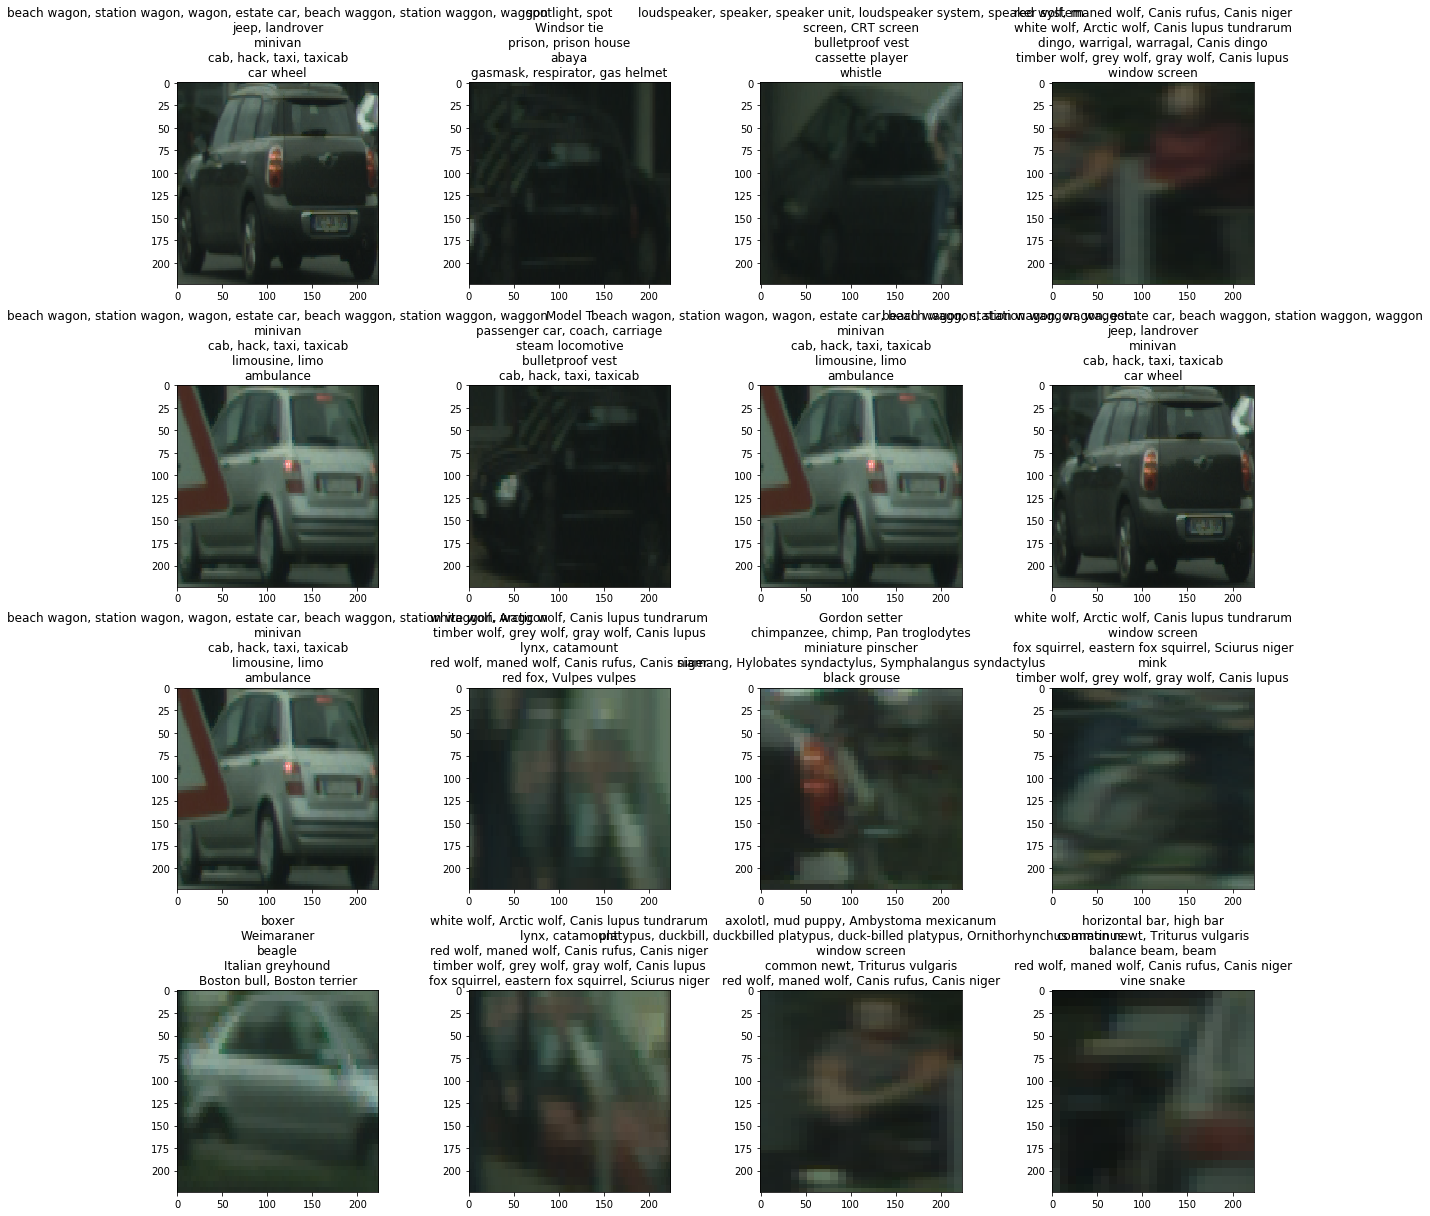

In [12]:
# Viz
grid_dim = int(math.sqrt(BATCH_SIZE))
f, axarr = plt.subplots(grid_dim, grid_dim)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
curr_row = 0
for index, tensor in enumerate(iputs):
    # fetch the url as a file type object, then read the image
    # find the column by taking the current index modulo 3
    col = index % grid_dim
    # plot on relevant subplot
    inv_img = reverse_trsf(tensor)
    axarr[col,curr_row].imshow(inv_img)
    top_classes = "\n".join([imagenet_class_map[j.item()] for j in indices[index]])
    axarr[col,curr_row].set_title(top_classes)
    if col == grid_dim-1:
        # we have finished the current row, so increment row counter
        curr_row += 1

In [10]:
# Manual verificiation
test_img = img_trsf(iputs[0])
plt.imshow(test_img)

transform = transforms.Compose([            #[1]
 #transforms.Resize(256),                    #[2]
 #transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
#  transforms.Normalize(                      #[5]
#  mean=[0.485, 0.456, 0.406],                #[6]
#  std=[0.229, 0.224, 0.225]                  #[7]
#  )
])

img_t = transform(test_img)
batch_t = torch.unsqueeze(img_t, 0)

# Second, put the network in eval mode
model.eval()
 
# Third, carry out model inference
out = model(batch_t)
 
# Forth, print the top 5 classes predicted by the model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(imagenet_class_map[idx.item()], percentage[idx].item()) for idx in indices[0][:5]]

NameError: name 'img_trsf' is not defined

In [13]:
targets

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 0, 0, 1, 4, 1])